- https://ivanpp.cc/detectron2-walkthrough-windows/#step3installdetectron2
- https://github.com/Layout-Parser/layout-parser/blob/master/docs/notes/modelzoo.md

In [1]:
import layoutparser as lp
from layoutparser.elements import *
import cv2

In [2]:
SCORE_THRESH_TEST = 0.7

In [3]:
model = lp.Detectron2LayoutModel(config_path =r'C:\Users\Bob\nb\layout-parser\models\PubLayNet\mask_rcnn_X_101_32x8d_FPN_3x\config.yaml',
                                 label_map   ={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}, # In model`label_map`
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", SCORE_THRESH_TEST], # Optional
                                 model_path  =r'C:\Users\Bob\nb\layout-parser\models\PubLayNet\mask_rcnn_X_101_32x8d_FPN_3x\model_final.pth')

C:\Users\Bob\nb\layout-parser\models\PubLayNet\mask_rcnn_X_101_32x8d_FPN_3x\config.yaml


The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [4]:
image = cv2.imread("../data/foo.0_raw.png")
image = image[..., ::-1] 

In [5]:
layout = model.detect(image)

C:\Users\Bob\anaconda3\envs\lp\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
C:\Users\Bob\anaconda3\envs\lp\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


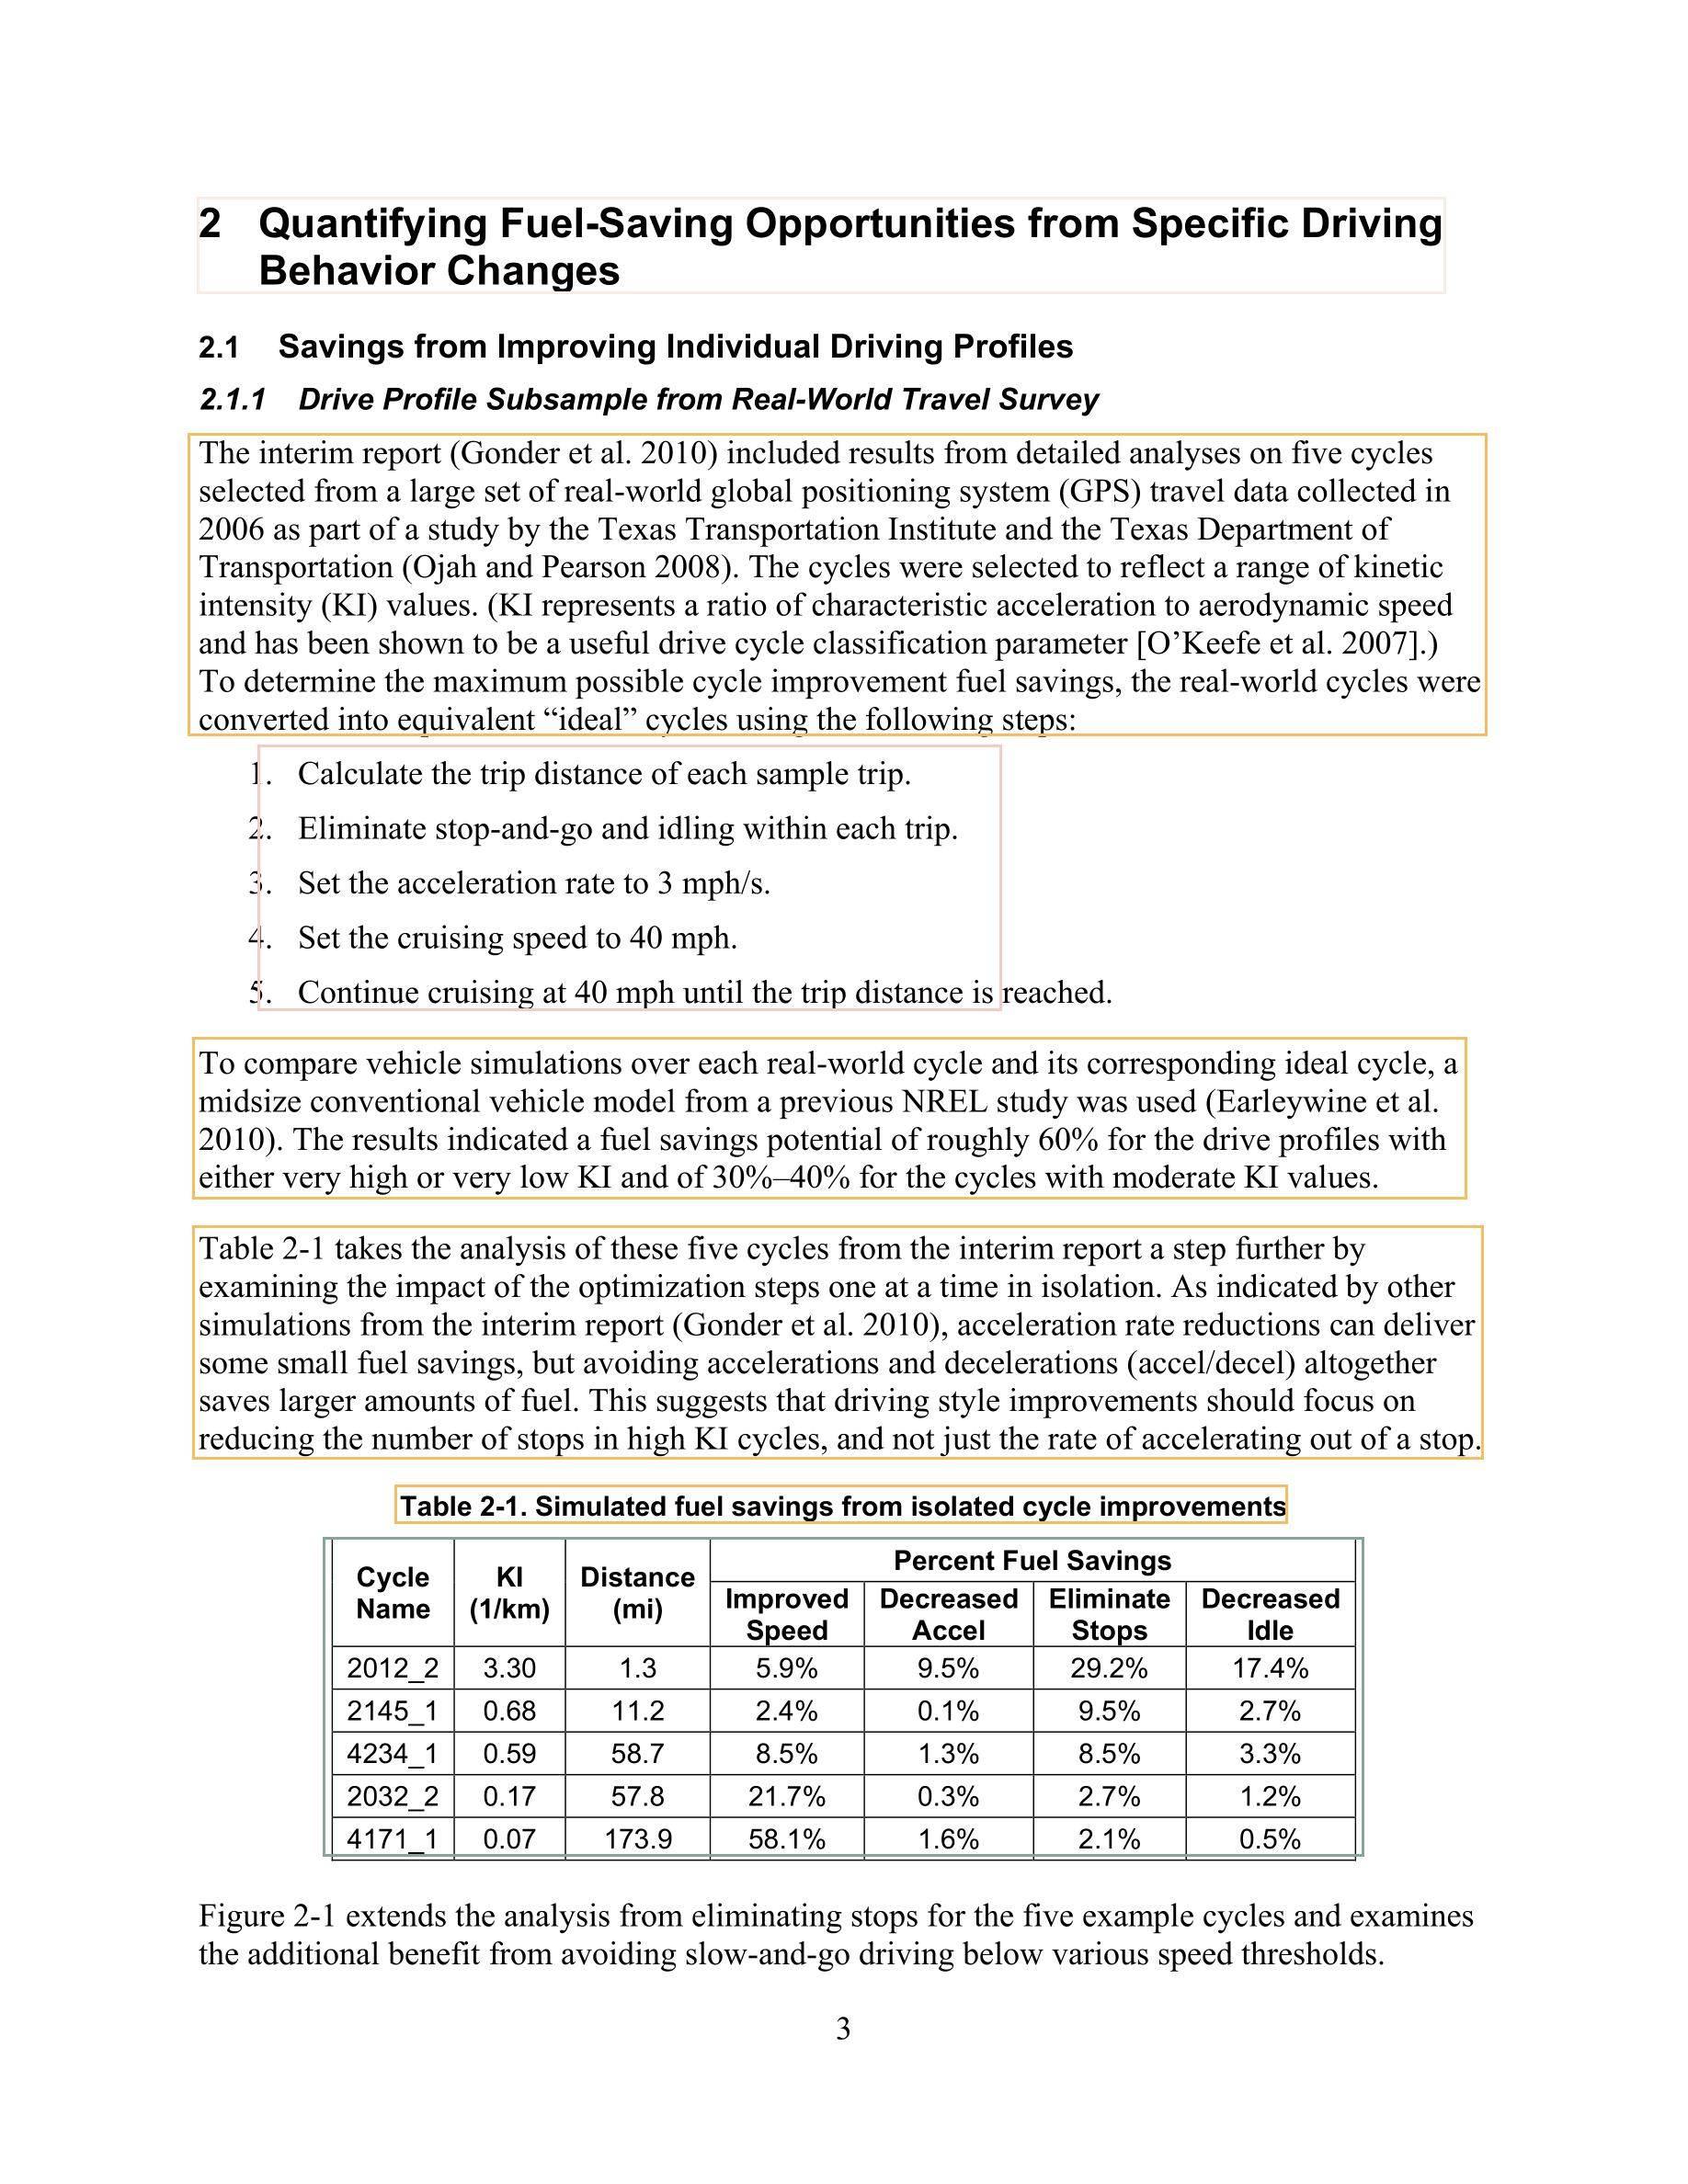

In [6]:
lp.draw_box(image, layout, box_width=3)

## Convert to ONNX
- pip install onnx==1.8.1 https://github.com/onnx/onnx/issues/582


python export_model.py --sample-image C:\Users\Bob\nb\layout-parser\data\foo.0_raw.png --config-file C:/Users/Bob/nb/layout-parser/models/PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config.yaml --output ./output --export-method caffe2_tracing --format onnx MODEL.WEIGHTS C:/Users/Bob/nb/layout-parser/models/PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/model_final.pth MODEL.DEVICE cpu 

### Note about Caffe2Tracer
**tracer = Caffe2Tracer(cfg, torch_model, inputs)**

Make a detectron2 model traceable with Caffe2 operators. This class creates a traceable version of a detectron2 model which:
1. Rewrite parts of the model using ops in Caffe2. Note that some ops do not have GPU implementation in Caffe2.
2. Remove post-processing and only produce raw layer outputs

After making a traceable model, the class provide methods to export such a model to different deployment formats. Exported graph produced by this class take two input tensors:
1. (1, C, H, W) float "data" which is an image (usually in [0, 255]). (H, W) often has to be padded to multiple of 32 (depend on the model architecture).
2. 1x3 float "im_info", each row of which is (height, width, 1.0). Height and width are true image shapes before padding.

The class currently only supports models using builtin meta architectures. Batch inference is not supported, and contributions are welcome.

## Updating Model's Inputs Outputs Dimension Sizes with Variable Length
https://github.com/onnx/onnx/blob/master/docs/PythonAPIOverview.md#updating-models-inputs-outputs-dimension-sizes-with-variable-length

Function update_inputs_outputs_dims updates the dimension of the inputs and outputs of the model, to the provided values in the parameter. You could provide both static and dynamic dimension size, by using dim_param. For more information on static and dynamic dimension size, checkout Tensor Shapes.

The function runs model checker after the input/output sizes are updated.

In [7]:
#import onnx
#from onnx.tools import update_model_dims

#model = onnx.load(r'C:\Users\Bob\nb\layout-parser\detectron2\tools\deploy\output\model.onnx')

# Here both 'seq', 'batch' and -1 are dynamic using dim_param.
#variable_length_model = update_model_dims.update_inputs_outputs_dims(model,
#            {'data': [1,3,1088,800], 'im_info': [1, 3]},
#            output_dims={'roi_bbox_nms': [-1, 4], '993':[-1], '992':[-1], 'value':[-1,5,28,28]})

In [8]:
#https://gitmemory.com/issue/facebookresearch/detectron2/2748/812922451
import onnx
import numpy as np
from caffe2.python.onnx import backend
#import torch
#from onnxruntime.backend.backend import OnnxRuntimeBackend as backend

In [10]:
onnx_model = onnx.load(r"C:\Users\Bob\nb\layout-parser\detectron2\tools\deploy\output\model.onnx")
onnx.checker.check_model(onnx_model)

In [11]:
#output = caffe2.python.onnx.backend.run_model(onnx_model, inputArray.astype(np.float32))
rep = backend.prepare(onnx_model)

C:\Users\Bob\anaconda3\envs\lp\lib\site-packages\caffe2\python\onnx\backend.py:690: UserWarning: Unrecognized operator set org.pytorch._caffe2
  warnings.warn("Unrecognized operator set {}".format(imp.domain))


In [13]:
height = 1088
width = 800
im = image

#scale_x = im.shape[0] / width
#scale_y = im.shape[1] / height
im = cv2.resize(im, (width, height))

# transpose needed
im = np.transpose(im, (2,0,1))

# Add one dimension
data = np.array([im])
data.shape

(1, 3, 1088, 800)

In [14]:
im_info = np.array([[height, width, 1]])
im_info.shape

(1, 3)

In [15]:
W = {
    'data': data.astype(np.float32),
    'im_info': im_info.astype(np.float32)
}

In [16]:
onnx_outputs = rep.run(W)

In [17]:
boxes  = onnx_outputs['roi_bbox_nms']
value  = onnx_outputs['value']
scores = onnx_outputs['993'] # not sure
labels = onnx_outputs['992'] # not sure

In [18]:
count = 0
layout_onnx = Layout()
for score, box, label in zip(scores, boxes, labels):
    x_1, y_1, x_2, y_2 = box

    #if self.label_map is not None:
    #    label = self.label_map.get(label, label)
    count = count + 1
    if score >= SCORE_THRESH_TEST:
        cur_block = TextBlock(
            Rectangle(x_1, y_1, x_2, y_2), type=label, score=score
        )
        layout_onnx.append(cur_block)

In [ ]:
len(layout_onnx)

In [ ]:
lp.draw_box(cv2.resize(image, (width, height)), layout_onnx, box_width=3)